In [1]:
!wget https://raw.githubusercontent.com/EdwardRaff/Inside-Deep-Learning/main/idlmam.py

--2023-05-13 16:25:20--  https://raw.githubusercontent.com/EdwardRaff/Inside-Deep-Learning/main/idlmam.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22064 (22K) [text/plain]
Saving to: ‘idlmam.py’

idlmam.py           100%[===================>]  21.55K  --.-KB/s    in 0.001s  

2023-05-13 16:25:20 (22.6 MB/s) - ‘idlmam.py’ saved [22064/22064]



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import os
from imageio import imread
from glob import glob
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import set_seed
from idlmam import train_network, Flatten, View, weight_reset, moveTo

<ipython-input-2-06e831761667>:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

torch.backends.cudnn.deterministic=True
set_seed(42)

<ipython-input-3-b32d05908c7c>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [4]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
#This URL has a copy of the dataset, make sure you go to Kaggle though and make an account and follow the license rules. 
data_url_zip = "https://github.com/kamalkraj/DATA-SCIENCE-BOWL-2018/blob/master/data/stage1_train.zip?raw=true"
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

#Download this dataset if we have not already done so
if not os.path.isdir('./data/stage1_train'):
  resp = urlopen(data_url_zip)
  os.makedirs("./data/stage1_train")
  zipfile = ZipFile(BytesIO(resp.read()))
  zipfile.extractall(path = './data/stage1_train')
#Grab all the paths to the images we just unziped 
paths = glob("./data/stage1_train/*")

In [ ]:
class MyDataset(Dataset):
  def __init__(self, path):
    self.paths = paths
  
  def __len__(self):
    return len(paths)

  def __getitem__(self, idx):
    img_path = glob(self.paths[idx] + "/images/*")[0]
    mask_imgs = glob(self.paths[idx] + "/masks/*")
    img = imread(img_path)[:,:,:3]
    img = np.moveaxis(img, -1, 0)
    img = img/255.0

    masks = [imread(f)/255.0 for f in mask_imgs]

    final_mask = np.zeros(masks[0].shape)
    for m in masks:
      final_mask = np.logical_or(final_mask, m)
    final_mask = final_mask.astype(np.float32)

    img, final_mask = torch.tensor(img), torch.tensor(final_mask).unsqueeze(0)
    img = F.interpolate(img.unsqueeze(0), (256, 256))
    final_mask = F.interpolate(final_mask.unsqueeze(0), (256, 256))
    return img.type(torch.FloatTensor)[0], final_mask.type(torch.FloatTensor)[0]

<ipython-input-7-a60e25ea94f3>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,:3]
<ipython-input-7-a60e25ea94f3>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks = [imread(f)/255.0 for f in mask_imgs]


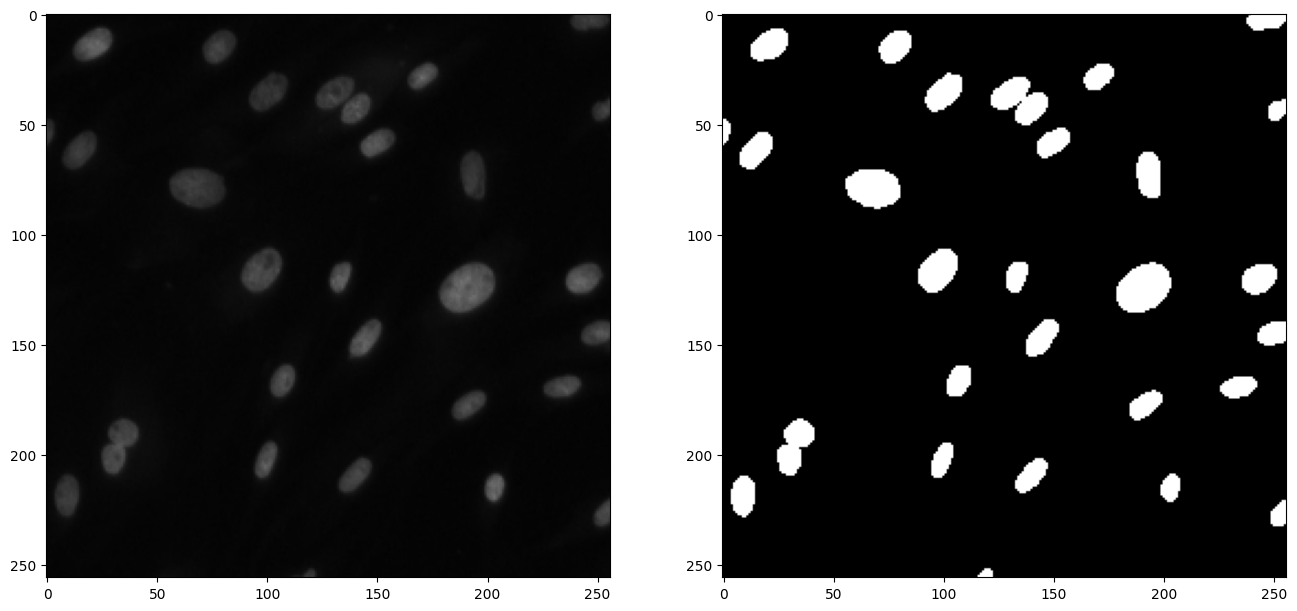

In [ ]:
data = MyDataset(paths)
plt.figure(figsize=(16, 10))
plt.subplot(1,2,1)
plt.imshow(data[0][0].permute(1,2,0).numpy())
plt.subplot(1,2,2)
plt.imshow(data[0][1].numpy()[0,:], cmap='gray');

In [ ]:
train_split, test_split = torch.utils.data.random_split(data, [500, len(data)-500])
train_loader = DataLoader(train_split, batch_size=16, shuffle=True)
test_loader = DataLoader(test_split, batch_size=16)

In [ ]:
C = 3
n_filters = 32
loss_func = nn.BCEWithLogitsLoss()

In [6]:
def cnn_layer(in_filters, out_filters, kernel_size=3):
  padding = kernel_size//2
  conv = nn.Sequential(
      nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
      nn.BatchNorm2d(out_filters),
      nn.LeakyReLU()
  )
  return conv


In [ ]:
model = nn.Sequential(
    cnn_layer(C, n_filters),
    *[cnn_layer(n_filters, n_filters) for _ in range(5)],
    nn.Conv2d(n_filters, 1, 3, padding=1)
)

In [ ]:
results = train_network(
    model, 
    loss_func, 
    train_loader, 
    epochs=10, 
    device=device, 
    val_loader=test_loader
)


<ipython-input-7-a60e25ea94f3>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,:3]
<ipython-input-7-a60e25ea94f3>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks = [imread(f)/255.0 for f in mask_imgs]


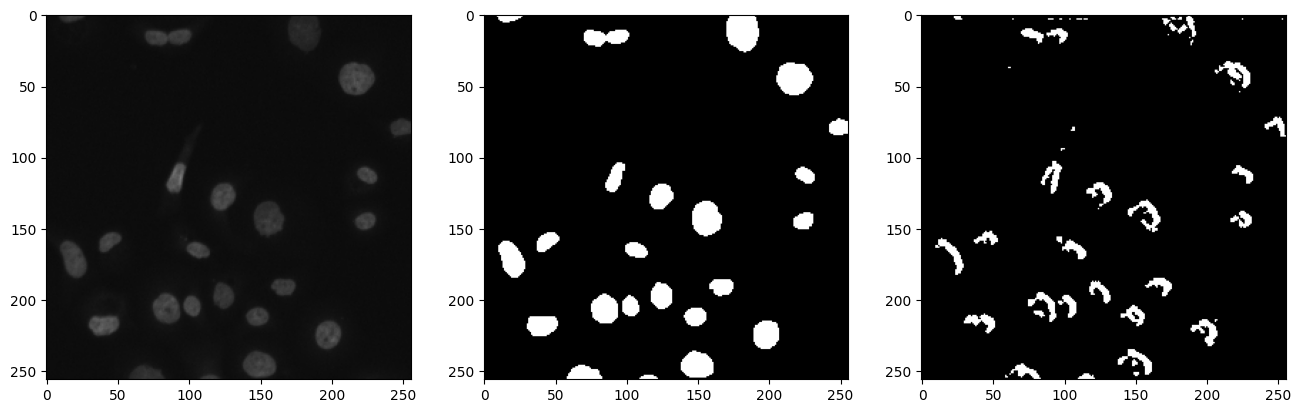

In [ ]:
index = 10 # Picking a specific example from the dataset that shows a particular result. Change this to look at other entries from the dataset.

with torch.no_grad():#We don't want gradients if we aren't training, so no gradients please!
    #push a test datapoint through the model. Remember the raw outputs are called the logits
    logits = model(test_split[index][0].unsqueeze(0).to(device))[0].cpu()
    #apply $\sigma$ to the logits to make predictions and then apply a threshold to get a prediction mask
    pred = torch.sigmoid(logits) >= 0.5

#Plot the input, ground truth, and prediction
plt.figure(figsize=(16,10))
plt.subplot(1, 3, 1)
plt.imshow(test_split[index][0].permute(1,2,0).numpy(), cmap='gray') #First plot the original input to the network
plt.subplot(1, 3, 2)
plt.imshow(test_split[index][1].numpy()[0,:], cmap='gray') #Second is ground truth
plt.subplot(1, 3, 3) 
plt.imshow(pred.numpy()[0,:], cmap='gray') #Third is the prediction our network made

In [ ]:
model2 = nn.Sequential(
    cnn_layer(C, n_filters),
    cnn_layer(n_filters, n_filters),
    nn.MaxPool2d(2), # shrink (H, W) by 2
    cnn_layer(n_filters, 2*n_filters),
    cnn_layer(2*n_filters, 2*n_filters),
    cnn_layer(2*n_filters, 2*n_filters),
    # Double (H, W) countering the effect of pooling before
    nn.ConvTranspose2d(2*n_filters, n_filters, 3, padding=1, output_padding=1, stride=2),
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(),
    # Back to normal conv
    cnn_layer(n_filters, n_filters), 
    nn.Conv2d(n_filters, 1, 3, padding=1)  # (B, 1 W, H)
)

In [ ]:
results = train_network(
    model2, 
    loss_func, 
    train_loader, 
    epochs=10, 
    device=device, 
    val_loader=test_loader
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

<ipython-input-7-a60e25ea94f3>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,:3]
<ipython-input-7-a60e25ea94f3>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks = [imread(f)/255.0 for f in mask_imgs]


Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

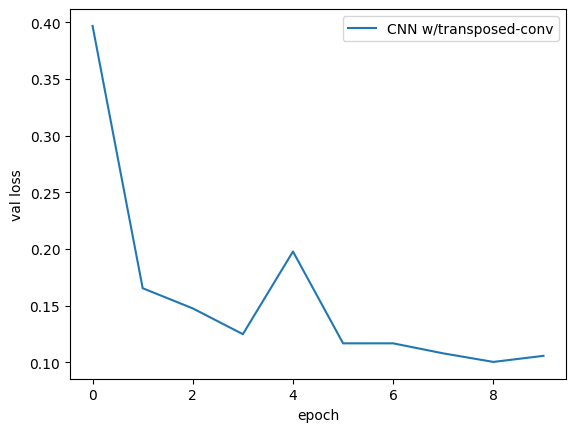

In [ ]:
sns.lineplot(x='epoch', y='val loss', data=results, label='CNN w/transposed-conv');

<ipython-input-7-a60e25ea94f3>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,:3]
<ipython-input-7-a60e25ea94f3>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks = [imread(f)/255.0 for f in mask_imgs]


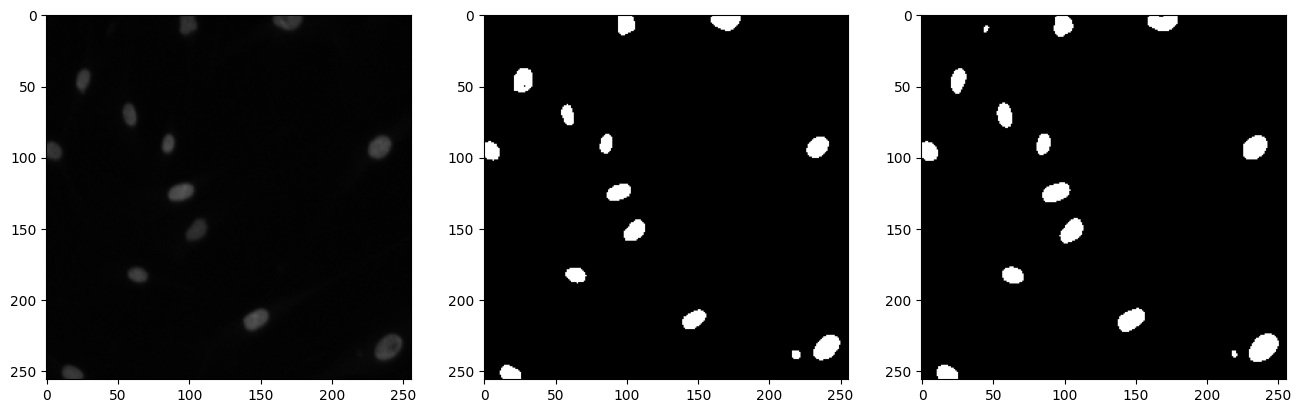

In [ ]:
index = 6 # Same example from before

with torch.no_grad(): #We don't want gradients if we aren't training, so no gradients please!
    #push a test datapoint through the model. Remember the raw outputs are called the logits
    logits = model2(test_split[index][0].unsqueeze(0).to(device))[0].cpu()
    #apply $\sigma$ to the logits to make predictions and then apply a threshold to get a prediction mask
    pred = torch.sigmoid(logits) >= 0.5


#Plot the input, ground truth, and prediction
plt.figure(figsize=(16,10))
plt.subplot(1, 3, 1)
plt.imshow(test_split[index][0].permute(1,2,0).numpy(), cmap='gray')  #First plot the original input to the network
plt.subplot(1, 3, 2)
plt.imshow(test_split[index][1].numpy()[0,:], cmap='gray') #Second is ground truth
plt.subplot(1, 3, 3)
plt.imshow(pred.numpy()[0,:], cmap='gray') #Third is the prediction our network made

In [ ]:
class UNetBlock2d(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels=None, sub_network=None, layers=1, filter_size=3):
    super().__init__()

    in_layers = [cnn_layer(in_channels, mid_channels, filter_size)]

    if sub_network is None:
      inputs_to_outputs = 1
    else:
      inputs_to_outputs = 2

    out_layers = [cnn_layer(mid_channels*inputs_to_outputs, mid_channels, filter_size)]

    for _ in range(layers-1):
      in_layers.append(cnn_layer(mid_channels, mid_channels, filter_size))
      out_layers.append(cnn_layer(mid_channels, mid_channels, filter_size))
    
    if out_channels is not None:
      out_layers.append(nn.Conv2d(mid_channels, out_channels, 1, padding=0))
    
    self.in_model = nn.Sequential(*in_layers)

    if sub_network is not None:
      self.bottleneck = nn.Sequential(
          nn.MaxPool2d(2),
          sub_network,
          nn.ConvTranspose2d(
              mid_channels,
              mid_channels,
              filter_size,
              padding=filter_size//2,
              output_padding=1,
              stride=2
          )
      )
    else:
      self.bottleneck = None
    self.out_model = nn.Sequential(*out_layers)


  def forward(self, x):
    full_scale_result = self.in_model(x)
    if self.bottleneck is not None:
      bottle_result = self.bottleneck(full_scale_result)
      full_scale_result = torch.cat([full_scale_result, bottle_result], dim=1)
    return self.out_model(full_scale_result)


In [ ]:
model = nn.Sequential(
    UNetBlock2d(3, 32, layers=2, sub_network=
        UNetBlock2d(32, 64, out_channels=32, layers=2, sub_network=
            UNetBlock2d(64, 128, out_channels=64, layers=2)
        ),
    ),
    #Prediction for _every_ location
    nn.Conv2d(32, 1, (3,3), padding=1), #Shape is now (B, 1, W, H)
)

In [ ]:
results = train_network(model, loss_func, train_loader, epochs=10, device=device, val_loader=test_loader)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

<ipython-input-7-a60e25ea94f3>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,:3]
<ipython-input-7-a60e25ea94f3>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks = [imread(f)/255.0 for f in mask_imgs]


Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
results

,epoch,total time,train loss,val loss
0,0,75.348182,0.335086,0.750596
1,1,134.386961,0.190217,0.189441
2,2,192.016702,0.156626,0.152815
3,3,249.912871,0.110491,0.105462
4,4,307.387593,0.102939,0.099785
5,5,363.482149,0.117070,0.157403
6,6,419.645607,0.109060,0.204407
7,7,475.991103,0.095722,0.091386
8,8,531.994557,0.086277,0.099257
9,9,588.533537,0.086768,0.114439


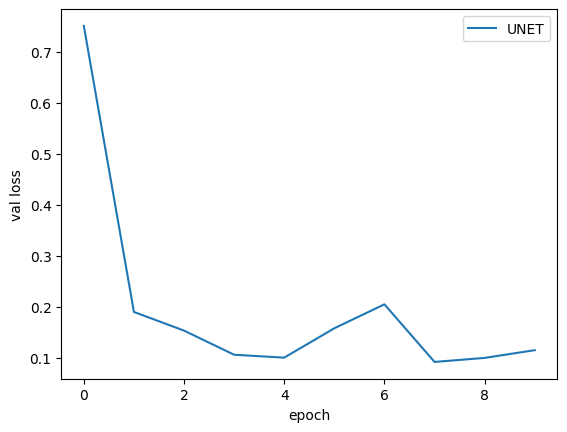

In [ ]:
sns.lineplot(x='epoch', y='val loss', data=results, label='UNET');

In [7]:
class Class2Detect(Dataset):
  """This class is used to create a simple converstion of a dataset from a classification problem, to a detection problem. """

  def __init__(self, dataset, toSample=3, canvas_size=100):
    """
    dataset: the source dataset to sample items from as the "objects" to detect
    toSample: the maximum number of "objects" to put into any image
    canvas_size: the width and height of the images to place objects inside of. 
    """
    self.dataset = dataset
    self.toSample = toSample
    self.canvas_size = canvas_size

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    
    boxes = []
    labels = []
    
    final_size = self.canvas_size
    #First, create a larger image that will store all the "objects" to detect
    img_p = torch.zeros((final_size,final_size), dtype=torch.float32)
    #Now we are going to sample up to self.toSample objects to place into the image
    for _ in range(np.random.randint(1,self.toSample+1)):
        
      #Pick an object at random from the original dataset, and its label
      img, label = self.dataset[np.random.randint(0,len(self.dataset))]
      #Get the height and width of that image
      _, img_h, img_w = img.shape
      #Pick a random offset of the x and y axis, essentially placing the image at a random location
      offsets = np.random.randint(0,final_size-np.max(img.shape),size=(4))
      #Change the padding at the end to make sure we come out to a specific 100,100 shape
      offsets[1] = final_size - img.shape[1] - offsets[0]
      offsets[3] = final_size - img.shape[2] - offsets[2]
      
      with torch.no_grad():
          img_p = img_p + F.pad(img, tuple(offsets))
      #Lets craete the values for the "boxes"
      #all of these are in absolute pixel locations
      
      #x_min determined by the randomly selected offset
      xmin = offsets[0]
      #x_max is the offset plus the image's width
      xmax = offsets[0]+img_w
      #y min/max follows the same pattern
      ymin = offsets[2]
      ymax = offsets[2]+img_h
      #now we add to the box with the right label
      boxes.append( [xmin, ymin, xmax, ymax] )
      labels.append( label )

        
    target = {}
    target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
    target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
    
    return img_p, target

In [8]:
train_data = Class2Detect(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data = Class2Detect(torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True))

def collate_fn(batch):
  imgs, labels = [], []
  for img, label in batch:
    imgs.append(img)
    labels.append(label)
  return imgs, labels

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=collate_fn)

100%|██████████| 9912422/9912422 [00:00<00:00, 97367461.31it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31455646.28it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25558656.84it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21405088.50it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



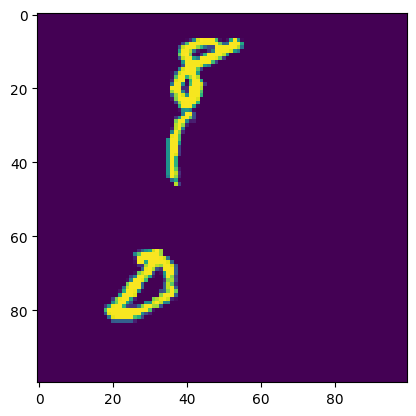

In [9]:
x, y = train_data[0]
imshow(x.numpy()[0,:])

In [10]:
C = 1
classes = 10
n_filters = 32

In [11]:
backbone = nn.Sequential(
    cnn_layer(C, n_filters),
    cnn_layer(n_filters, n_filters),
    cnn_layer(n_filters, n_filters),
    nn.MaxPool2d((2, 2,)),
    cnn_layer(n_filters, 2*n_filters),
    cnn_layer(2*n_filters, 2*n_filters),
    cnn_layer(2*n_filters, 2*n_filters),
    nn.MaxPool2d((2, 2)),
    cnn_layer(2*n_filters, 4*n_filters),
    cnn_layer(4*n_filters, 4*n_filters),
)

backbone.out_channels = n_filters*4

In [12]:
anchor_generator = AnchorGenerator(sizes=((32),), aspect_ratios=((1.0,)))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=8, sampling_ratio=2)
model = FasterRCNN(
    backbone, 
    num_classes=10, 
    image_mean = [0.5], 
    image_std = [0.229], 
    min_size=100, 
    max_size=100, 
    rpn_anchor_generator=anchor_generator, 
    box_roi_pool=roi_pooler)


In [13]:
model = model.train()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters())

for epoch in tqdm(range(1), desc="Epoch", disable=False):
  running_loss = 0
  for x, y in tqdm(train_loader, desc="Train Batch", leave=False, disable=False):
    x, y = moveTo(x, device), moveTo(y, device)
    optimizer.zero_grad()
    losses = model(x, y)
    loss = 0
    for partial_loss in losses.values():
      loss += partial_loss
    loss.backward()

    optimizer.step()
    running_loss += loss.item()

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/469 [00:00<?, ?it/s]

In [31]:
x, y = test_data[20]

model.eval()
model.to(device)
with torch.inference_mode():
  pred = model([x.to(device)])

In [32]:
pred

[{'boxes': tensor([[24.2751, 71.6908, 52.4614, 99.2336],
          [24.1852, 73.4558, 52.6929, 97.9468],
          [58.9239, 28.6095, 87.1263, 56.7581],
          [61.1304, 26.7811, 89.1353, 54.5272],
          [57.3377, 31.5287, 86.1277, 59.8870],
          [58.6477, 30.8701, 86.8608, 59.5085],
          [62.2379, 29.4292, 90.8559, 58.1059],
          [62.8268, 29.0224, 91.1225, 57.4738],
          [57.1549, 30.3144, 85.5534, 58.1949],
          [60.8507, 31.1386, 89.8647, 59.6259]], device='cuda:0'),
  'labels': tensor([6, 8, 8, 9, 6, 2, 1, 7, 5, 4], device='cuda:0'),
  'scores': tensor([0.8320, 0.5824, 0.5326, 0.5219, 0.1476, 0.1329, 0.1053, 0.1049, 0.0758,
          0.0525], device='cuda:0')}]

In [34]:
import matplotlib.patches as patches
from torchvision.ops import nms


In [37]:
def plotDetection(ax, abs_pos, label=None):
  """
  ax: the matpllib axis to add this plot to
  abs_pos: the positions of the bounding box
  label: the label of the prediction to add
  """
  x1, y1, x2, y2 = abs_pos
  #make a rectangle for the bounding box
  rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  #add the label if given
  if label is not None:
    plt.text(x1+0.5, y1, label, color='black', bbox=dict(facecolor='white', edgecolor='white', pad=1.0))
  
  return 

def showPreds(img, pred, iou_max_overlap=0.5, min_score=0.05, label_names=None):
  """
  img: the original image object detection was performed on
  pred: the output dictionary from FasterRCNN for evaluation on img
  iou_max_overlap: the iou threshold at which non-maximum suppression will be performed
  min_score: the minimum RPN network score to consider an object
  """
  fig,ax = plt.subplots(1)
  img = img.cpu().numpy()
  if img.shape[0] == 1:
    ax.imshow(img[0,:])
  else:
    ax.imshow(np.moveaxis(img, 0, 2))
  boxes = pred['boxes'].cpu()
  labels = pred['labels'].cpu()
  scores = pred['scores'].cpu()
  
  selected = nms(boxes, scores, iou_max_overlap).cpu().numpy()
  
  for i in selected:
    if scores[i].item() > min_score:
      if label_names is None:
        label = str(labels[i].item())
      else:
        label = label_names[labels[i].item()]
      plotDetection(ax, boxes[i].cpu().numpy(), label=label)
  
  plt.show()

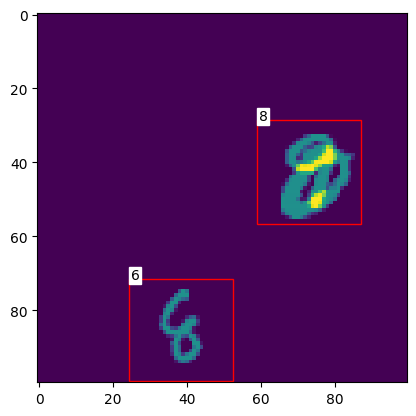

In [36]:
showPreds(x, pred[0])